# Visualize and Compare Activation Functions

We'll train a simple MLP on **MNIST** using **Sigmoid**, **Tanh**, and **ReLU** activations.

We'll compare:
- Training speed (epochs to reach ~90% val accuracy)
- Final accuracy
- Gradient flow (via histograms)

Uses **Keras** with minimal code.

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

# Use subset for speed (5000 train, 1000 test)
x_train, y_train = x_train[:5000], y_train[:5000]
x_test, y_test = x_test[:1000], y_test[:1000]

print(f"Train: {x_train.shape}, Test: {x_test.shape}")

Train: (5000, 784), Test: (1000, 784)


## Define MLP Model Builder

In [4]:
def build_mlp(activation):
    model = keras.Sequential([
        layers.Dense(128, activation=activation, input_shape=(784,), name="hidden1"),
        layers.Dense(128, activation=activation, name="hidden2"),
        layers.Dense(10, activation="softmax", name="output")
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

## Train Models & Record History

In [5]:
activations = ["sigmoid", "tanh", "relu"]
histories = {}
models = {}

for act in activations:
    print(f"\nTraining with {act.upper()}...")
    model = build_mlp(act)
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=30,
        batch_size=128,
        verbose=1
    )
    histories[act] = history
    models[act] = model


Training with SIGMOID...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2676 - loss: 2.2012 - val_accuracy: 0.5680 - val_loss: 1.7453
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6320 - loss: 1.5301 - val_accuracy: 0.7050 - val_loss: 1.1497
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7628 - loss: 0.9867 - val_accuracy: 0.7940 - val_loss: 0.8232
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8384 - loss: 0.6991 - val_accuracy: 0.8420 - val_loss: 0.6510
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8760 - loss: 0.5417 - val_accuracy: 0.8620 - val_loss: 0.5506
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8997 - loss: 0.4457 - val_accuracy: 0.8720 - val_loss: 0.4879
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9117 - loss: 0.3829 - val_accuracy: 0.8730 - val_loss: 0.4462
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9183 - loss: 0.3394 - val_accuracy: 0.8780 - val_loss: 0.4167
E

## Plot Training Speed & Accuracy

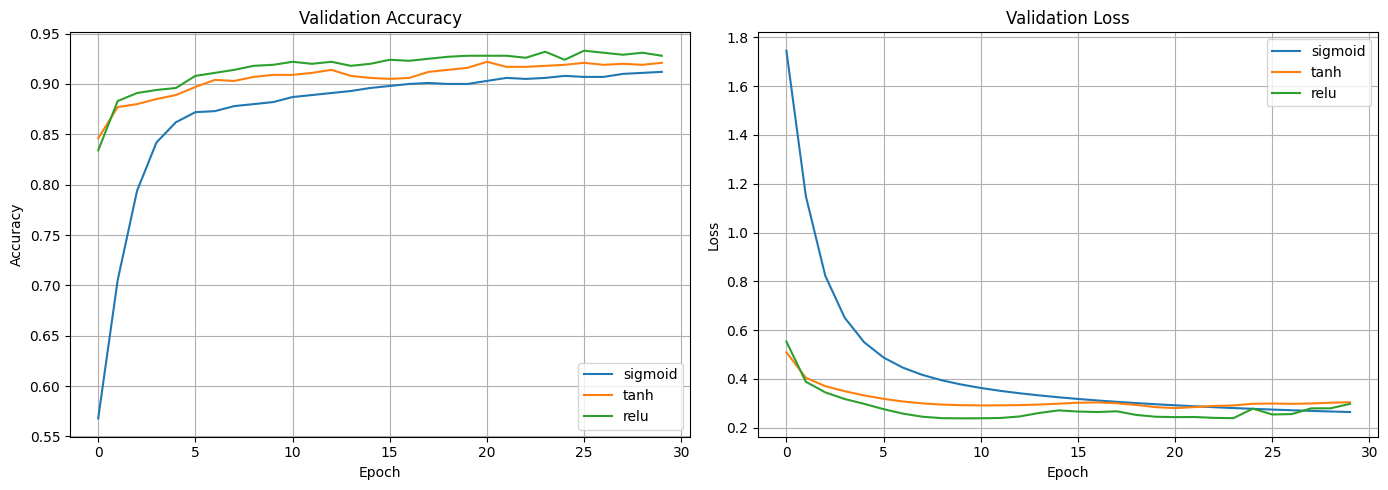

In [6]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
for act in activations:
    plt.plot(histories[act].history['val_accuracy'], label=f'{act}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
for act in activations:
    plt.plot(histories[act].history['val_loss'], label=f'{act}')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Gradient Flow Analysis (After Training)
We'll compute gradients w.r.t. input for a batch and plot histograms.

In [7]:
@tf.function
def get_gradients(model, x_batch):
    with tf.GradientTape() as tape:
        tape.watch(x_batch)
        preds = model(x_batch)
        loss = tf.reduce_mean(preds)  # dummy loss
    grads = tape.gradient(loss, model.trainable_variables)
    return grads

# Take one batch
x_batch = tf.convert_to_tensor(x_test[:128])

grad_norms = {act: [] for act in activations}

for act in activations:
    model = models[act]
    grads = get_gradients(model, x_batch)
    for g in grads:
        if g is not None:
            grad_norms[act].append(tf.norm(g).numpy())

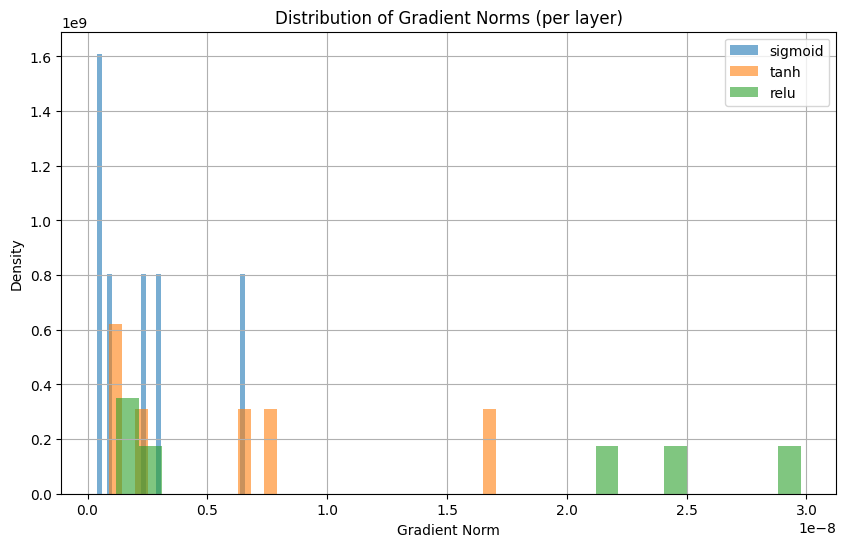

In [8]:
plt.figure(figsize=(10, 6))
for i, act in enumerate(activations):
    plt.hist(grad_norms[act], bins=30, alpha=0.6, label=f'{act}', density=True)
plt.title('Distribution of Gradient Norms (per layer)')
plt.xlabel('Gradient Norm')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

## Final Results Summary

In [9]:
print("Final Validation Accuracy:")
for act in activations:
    acc = max(histories[act].history['val_accuracy'])
    print(f"{act.upper():6} -> {acc:.4f}")

Final Validation Accuracy:
SIGMOID -> 0.9120
TANH   -> 0.9220
RELU   -> 0.9330


## Discussion: Vanishing/Exploding Gradients

| Activation | Issue | Observation |
|----------|-------|-----------|
| **Sigmoid** | **Vanishing gradients** | Outputs in [0,1] → gradients ≤ 0.25 → multiply → near zero in deep nets |
| **Tanh**     | Vanishing (less severe) | Outputs in [-1,1] → gradients ≤ 1 → still vanish, but better than sigmoid |
| **ReLU**     | **Dying ReLU**, possible exploding | No vanishing if neuron active; gradients = 1 → stable flow |

**From plots**:
- **ReLU** converges **fastest**
- **Sigmoid** is **slowest**, low accuracy
- **Tanh** in between
- **Gradient norms**: Sigmoid → very small (vanishing), ReLU → healthy spread

> **Conclusion**: ReLU is preferred in practice due to faster training and no vanishing gradients.